In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import random

import json
import torch
import sys
from torch.utils.data import DataLoader, Subset, RandomSampler
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch.nn as nn
from torchmetrics.classification import BinaryF1Score
from torchmetrics import Dice
from safetensors.torch import load_model
import segmentation_models_pytorch as smp


# Add the parent directory to sys.path
sys.path.append(os.path.dirname(os.path.realpath(os.path.abspath(""))))

from unet.train_dataset import DeadwoodDataset
from unet.unet_model import UNet
import matplotlib.pyplot as plt
import seaborn as sns

/net/home/jmoehring/.conda/envs/sd-env-12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1

In [3]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
register_df = pd.read_csv("/net/home/jmoehring/scratch/tiles/register.csv")
dataset = DeadwoodDataset(
    register_df=register_df,
    images_dir="/net/home/jmoehring/scratch/tiles",
    no_folds=3,
    random_seed=seed,
    test_size=0,
    verbose=True,
)

In [7]:
biome_dict = {
    1: "Tropical and Subtropical Moist Broadleaf Forests",
    2: "Tropical and Subtropical Dry Broadleaf Forests",
    3: "Tropical and Subtropical Coniferous Forests",
    4: "Temperate Broadleaf and Mixed Forests",
    5: "Temperate Coniferous Forests",
    6: "Boreal Forests/Taiga",
    7: "Tropical and Subtropical Grasslands, Savannas, and Shrublands",
    8: "Temperate Grasslands, Savannas, and Shrublands",
    9: "Flooded Grasslands and Savannas",
    10: "Montane Grasslands and Shrublands",
    11: "Tundra",
    12: "Mediterranean Forests, Woodlands, and Scrub",
    13: "Deserts and Xeric Shrublands",
    14: "Mangroves",
}

In [8]:
register_df["biome_name"] = register_df["biome"].map(biome_dict)

In [58]:
register_df.to_csv("/net/scratch/jmoehring/meta/register_biome.csv", index=False)

In [47]:
biome_g_df = register_df.groupby("biome_name").size().reset_index(name="count")

In [42]:
conti_df = pd.crosstab(register_df["biome_name"], register_df["resolution_bin"])

In [43]:
conti_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, Boreal Forests/Taiga to Tropical and Subtropical Moist Broadleaf Forests
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0.0     8 non-null      int64
 1   0.02    8 non-null      int64
 2   0.04    8 non-null      int64
 3   0.06    8 non-null      int64
 4   0.08    8 non-null      int64
 5   0.1     8 non-null      int64
 6   0.12    8 non-null      int64
 7   0.14    8 non-null      int64
 8   0.16    8 non-null      int64
 9   0.18    8 non-null      int64
 10  0.2     8 non-null      int64
 11  0.22    8 non-null      int64
 12  0.24    8 non-null      int64
 13  0.26    8 non-null      int64
 14  0.28    8 non-null      int64
dtypes: int64(15)
memory usage: 1.0+ KB


In [46]:
conti_df = conti_df.sort_values(by="0.0")

KeyError: '0.0'

In [11]:
conti_df.to_csv("~/scratch/meta/conti_biome_resolution.csv")

In [5]:
weights = dataset.get_train_sample_weights(fold=0, balancing_factor=0.9)

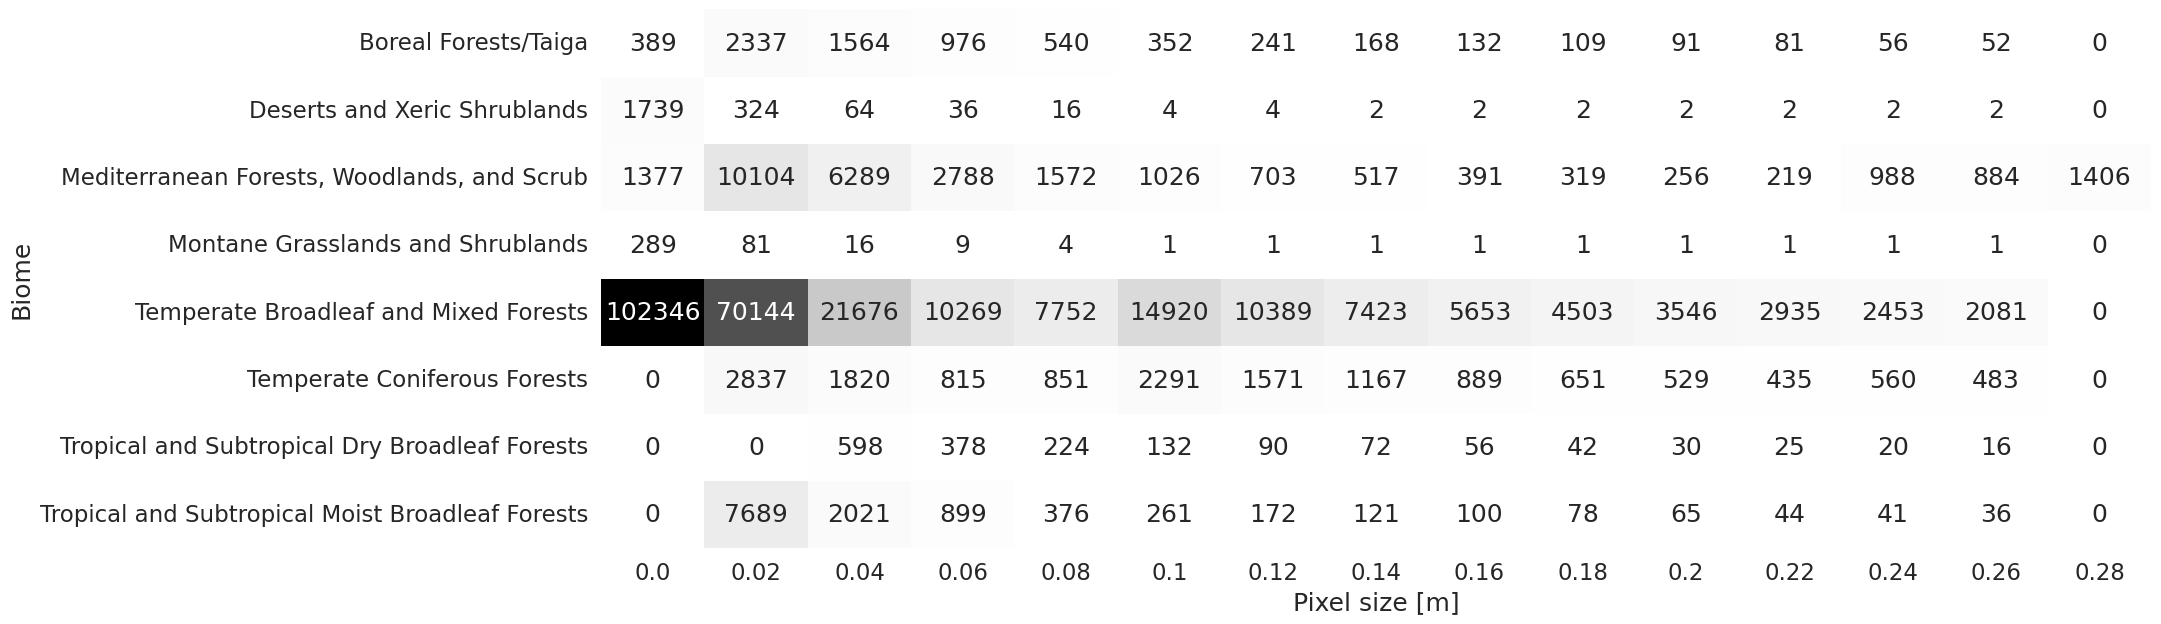

In [56]:
# plot contigency matrix for register based on resolution_bin and biome columns
# resolution_bin
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
plt.figure(figsize=(20, 7))
sns.heatmap(
    pd.crosstab(register_df["biome_name"], register_df["resolution_bin"]),
    annot=True,
    fmt="d",
    cmap="binary",
    cbar=False,
)
plt.xlabel("Pixel size [m]")
plt.ylabel("Biome")
# plt.title("Contingency matrix for resolution_bin and biome")
plt.show()

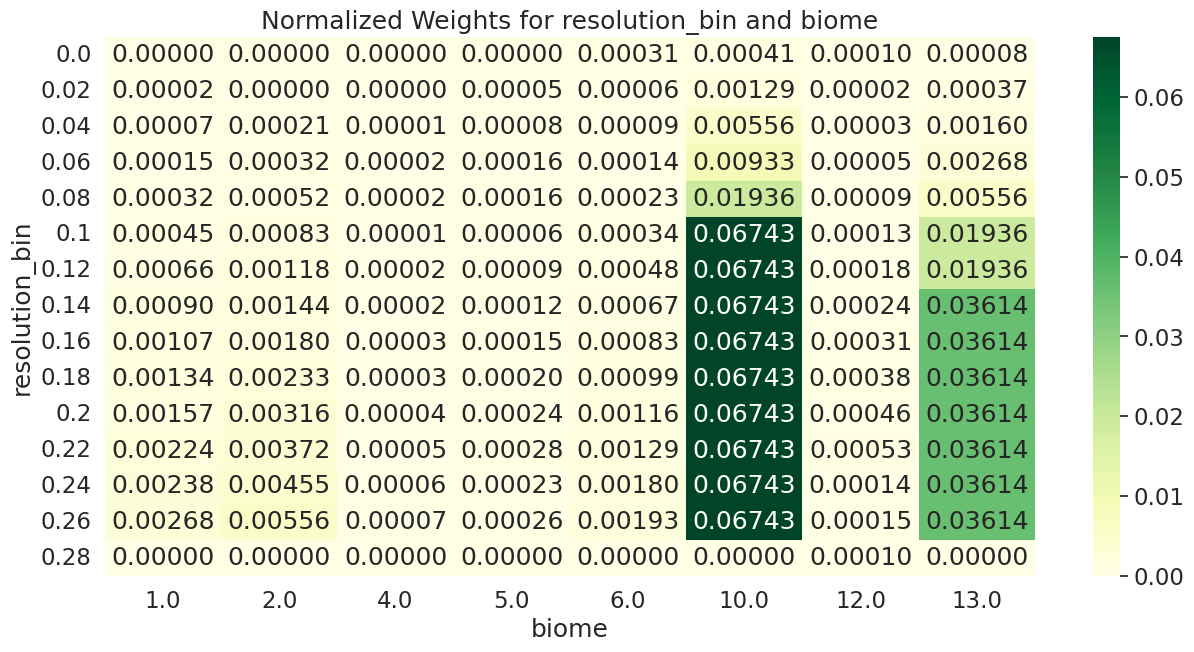

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming register_df is your DataFrame with 'resolution_bin' and 'biome' columns
# Create the contingency matrix
contingency_matrix = pd.crosstab(register_df["resolution_bin"], register_df["biome"])

# Calculate proportions
proportions = contingency_matrix / contingency_matrix.sum().sum()

# Compute weights as the inverse of the proportions
weights = (1 / proportions.replace(0, np.nan)) ** 0.9  # Avoid division by zero
weights = weights.fillna(0)  # Replace NaN values with 0

# Normalize weights
normalized_weights = weights / weights.sum().sum()

# Plotting the normalized weights
plt.figure(figsize=(15, 7))
sns.heatmap(
    normalized_weights,
    annot=True,
    fmt=".5f",
    cmap="YlGn",
    cbar=True,
)
plt.title("Normalized Weights for resolution_bin and biome")
plt.show()

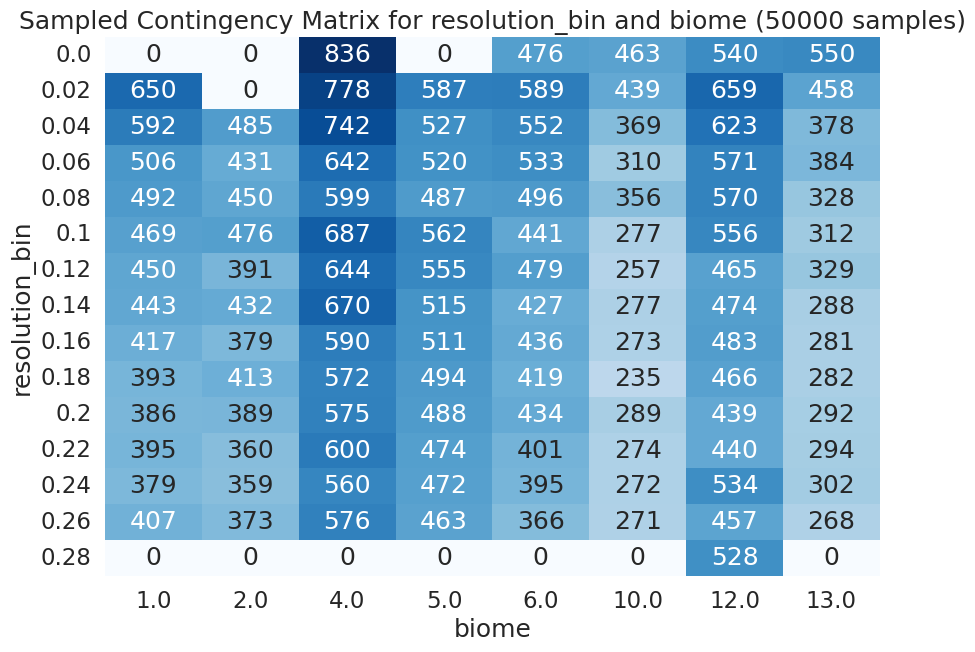

In [14]:
# map the weights to the register_df
register_df["weights"] = register_df.apply(
    lambda x: normalized_weights.loc[x["resolution_bin"], x["biome"]], axis=1
)
# Sample 10000 samples using the normalized weights
sampled_data = register_df.sample(
    n=50000, weights=register_df["weights"].values.flatten(), replace=True
)
# Create a new contingency table from the sampled data
sampled_contingency_matrix = pd.crosstab(
    sampled_data["resolution_bin"], sampled_data["biome"]
)
# Plotting the sampled contingency matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    sampled_contingency_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
)
plt.title("Sampled Contingency Matrix for resolution_bin and biome (50000 samples)")
plt.show()

In [9]:
weights = dataset.get_train_sample_weights(0, balancing_factor=0.9)